# Regional Trends & Segmentation EDA
This notebook deep-dives into seasonal dynamics, price growth cycles, buyer segmentation, and eircode-level signals using the processed Irish Property Price Register dataset. Analyses focus on insights not covered by the initial exploration or the new-versus-second-hand comparison notebooks.

## Objectives
- Quantify seasonal patterns and their evolution
- Measure county-level price and volume growth to spot market cycles
- Understand buyer segmentation through price bands and regulatory indicators
- Surface eircode routing-key hotspots for new builds and pricing pressure

In [1]:
# Imports and plotting defaults
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style='whitegrid', palette='crest')
%matplotlib inline

In [2]:
# Load consolidated dataset
DATA_PATH = Path('../data/processed/ppr_consolidated.parquet')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Missing processed dataset at {DATA_PATH}')

df = pd.read_parquet(DATA_PATH).copy()
df['sale_date'] = pd.to_datetime(df['sale_date'])

print('Dataset loaded successfully')
print(f"Shape: {df.shape}")
print(f"Date range: {df['sale_date'].min().date()} to {df['sale_date'].max().date()}")
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully
Shape: (752907, 12)
Date range: 2010-01-01 to 2025-11-07
Columns: ['sale_date', 'address', 'county', 'eircode', 'price_eur', 'not_full_market_price', 'vat_exclusive', 'property_description', 'property_size_category', 'year', 'month', 'quarter']


In [3]:
# Feature engineering for advanced slices
analysis_df = df[df['price_eur'].notnull() & (df['price_eur'] > 0)].copy()
analysis_df['sale_year'] = analysis_df['sale_date'].dt.year
analysis_df['sale_month'] = analysis_df['sale_date'].dt.month
analysis_df['sale_quarter'] = analysis_df['sale_date'].dt.to_period('Q').astype(str)
analysis_df['sale_month_start'] = analysis_df['sale_date'].dt.to_period('M').dt.to_timestamp()

month_order = pd.date_range('2000-01-01', periods=12, freq='MS').strftime('%b').tolist()
month_map = {i + 1: name for i, name in enumerate(month_order)}
analysis_df['sale_month_name'] = analysis_df['sale_month'].map(month_map)
analysis_df['sale_month_name'] = pd.Categorical(analysis_df['sale_month_name'], categories=month_order, ordered=True)

# Routing key derivation (first three chars of Eircode)
eircode_col = next((col for col in analysis_df.columns if col.lower() == 'eircode'), None)
if eircode_col:
    routing_key = (analysis_df[eircode_col].astype(str)
                   .str.upper()
                   .str.strip()
                   .str[:3])
    routing_key = routing_key.where(routing_key.str.len() == 3)
else:
    routing_key = pd.Series(index=analysis_df.index, dtype='object')

analysis_df['routing_key'] = routing_key.fillna('UNKNOWN')
analysis_df['routing_key_available'] = analysis_df['routing_key'] != 'UNKNOWN'

# Supply segment (New Build vs Second-Hand)
desc_col = next((col for col in analysis_df.columns if 'description' in col.lower()), None)
desc_tokens = analysis_df[desc_col].fillna('').str.upper() if desc_col else pd.Series('', index=analysis_df.index)
vat_col = next((col for col in analysis_df.columns if 'vat' in col.lower()), None)
vat_flags = analysis_df[vat_col] if vat_col else pd.Series(False, index=analysis_df.index)

analysis_df['is_new_build'] = ((vat_flags == True) | desc_tokens.str.contains('NEW', regex=False))
analysis_df['supply_segment'] = np.where(analysis_df['is_new_build'], 'New Build', 'Second-Hand')

# Price bands
price_bins = [-np.inf, 250_000, 500_000, 1_000_000, np.inf]
price_labels = ['<=EUR250k', 'EUR250k-500k', 'EUR500k-1M', '>EUR1M']
analysis_df['price_band'] = pd.cut(analysis_df['price_eur'], bins=price_bins, labels=price_labels)

RECENT_YEAR_START = analysis_df['sale_year'].max() - 4
print(f"Clean records: {len(analysis_df):,}")
print(f"Recent window start year: {RECENT_YEAR_START}")
print(f"Rows with routing keys: {analysis_df['routing_key_available'].mean() * 100:.1f}%")

Clean records: 752,907
Recent window start year: 2021
Rows with routing keys: 100.0%


## 1. Seasonal Dynamics

In [4]:
# Seasonal aggregates
monthly_totals = (analysis_df
                  .groupby(['sale_year', 'sale_month'])
                  .agg(avg_price=('price_eur', 'mean'),
                       transactions=('price_eur', 'count'))
                  .reset_index())
monthly_totals['month_name'] = monthly_totals['sale_month'].map(month_map)
monthly_totals['period_start'] = pd.to_datetime(dict(year=monthly_totals['sale_year'],
                                                     month=monthly_totals['sale_month'],
                                                     day=1))

seasonal_profile = (analysis_df
                    .groupby('sale_month')
                    .agg(avg_price=('price_eur', 'mean'),
                         median_price=('price_eur', 'median'),
                         avg_transactions=('price_eur', 'count')))
seasonal_profile['month_name'] = seasonal_profile.index.map(month_map)
recent_mask = analysis_df['sale_year'] >= RECENT_YEAR_START
recent_profile = (analysis_df[recent_mask]
                  .groupby('sale_month')['price_eur']
                  .mean())
seasonal_profile['recent_avg_price'] = seasonal_profile.index.map(recent_profile)
seasonal_profile['price_shift_vs_long_term'] = seasonal_profile['recent_avg_price'] - seasonal_profile['avg_price']
seasonal_profile = seasonal_profile.sort_index()

print("Seasonal profile (top rows):")
display(seasonal_profile[['avg_price', 'recent_avg_price', 'price_shift_vs_long_term']])

Seasonal profile (top rows):


,avg_price,recent_avg_price,price_shift_vs_long_term
sale_month,,,
1,"294,156.89","358,894.86","64,737.97"
2,"302,057.20","376,721.35","74,664.15"
3,"298,091.91","367,499.84","69,407.93"
4,"304,963.59","386,586.58","81,622.99"
5,"293,626.85","367,935.50","74,308.64"
6,"314,301.10","385,945.65","71,644.55"
7,"315,926.47","388,063.20","72,136.73"
8,"319,150.10","396,116.49","76,966.40"
9,"319,626.23","410,589.33","90,963.10"


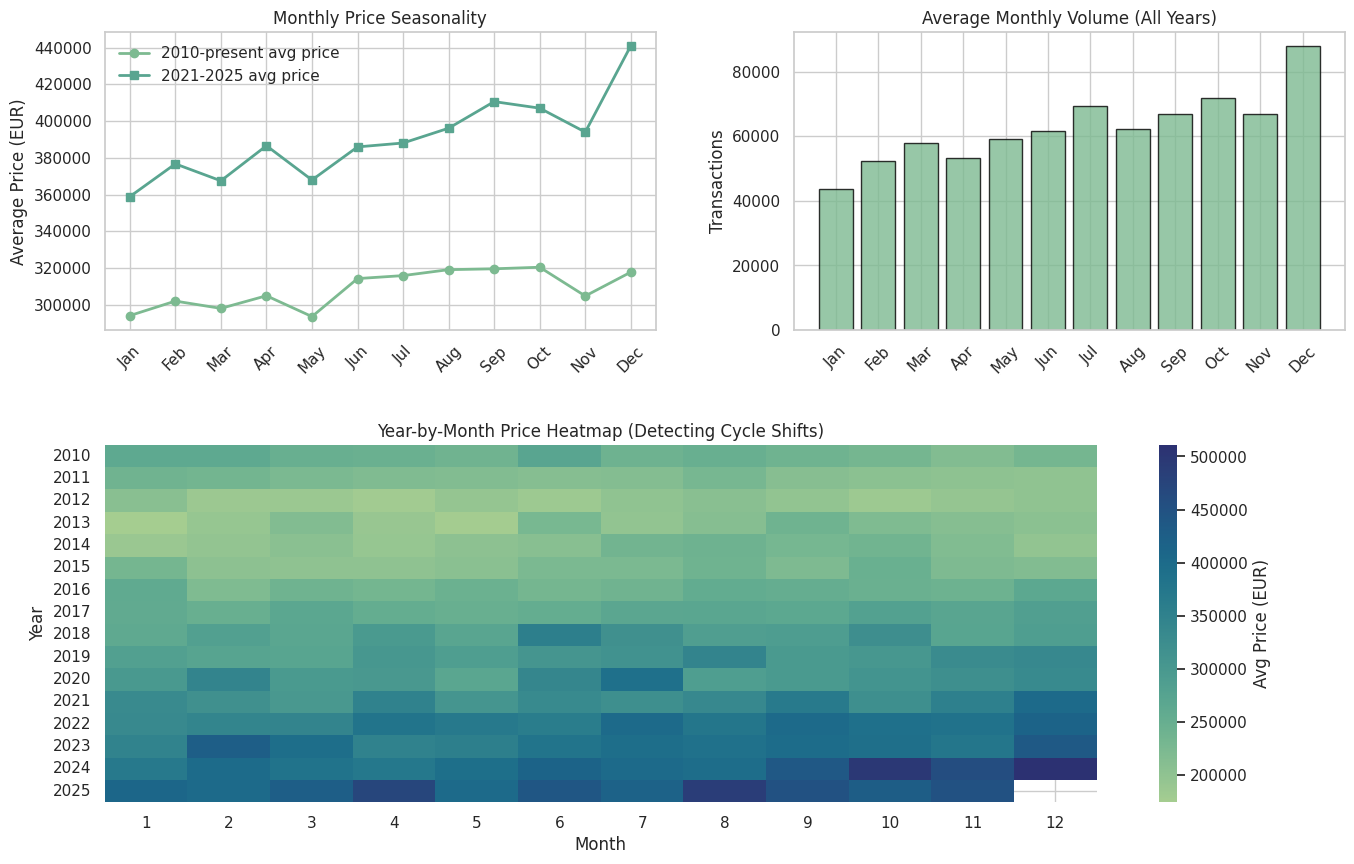

Top seasonal price peaks (recent average):


,month_name,recent_avg_price,price_shift_vs_long_term
sale_month,,,
12,Dec,"440,960.11","123,153.61"
9,Sep,"410,589.33","90,963.10"
10,Oct,"407,023.79","86,549.43"


In [5]:
# Visualize seasonal behavior
latest_year = int(analysis_df['sale_year'].max())
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], hspace=0.35, wspace=0.25)

months_idx = np.arange(1, 13)
long_term = seasonal_profile['avg_price'].values
recent = seasonal_profile['recent_avg_price'].values
month_labels = seasonal_profile['month_name']

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(months_idx, long_term, marker='o', linewidth=2, label='2010-present avg price')
ax1.plot(months_idx, recent, marker='s', linewidth=2, label=f'{RECENT_YEAR_START}-{latest_year} avg price')
ax1.set_xticks(months_idx)
ax1.set_xticklabels(month_labels, rotation=45)
ax1.set_ylabel('Average Price (EUR)')
ax1.set_title('Monthly Price Seasonality')
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(months_idx, seasonal_profile['avg_transactions'], alpha=0.8, edgecolor='black')
ax2.set_xticks(months_idx)
ax2.set_xticklabels(month_labels, rotation=45)
ax2.set_ylabel('Transactions')
ax2.set_title('Average Monthly Volume (All Years)')

heatmap_data = monthly_totals.pivot(index='sale_year', columns='sale_month', values='avg_price')
ax3 = fig.add_subplot(gs[1, :])
sns.heatmap(heatmap_data, cmap='crest', ax=ax3, cbar_kws={'label': 'Avg Price (EUR)'})
ax3.set_xlabel('Month')
ax3.set_ylabel('Year')
ax3.set_title('Year-by-Month Price Heatmap (Detecting Cycle Shifts)')
plt.show()

# Highlight peak months
seasonal_sorted = seasonal_profile.sort_values('recent_avg_price', ascending=False).head(3)
print('Top seasonal price peaks (recent average):')
display(seasonal_sorted[['month_name', 'recent_avg_price', 'price_shift_vs_long_term']])

## 2. County Price Growth & Market Cycles

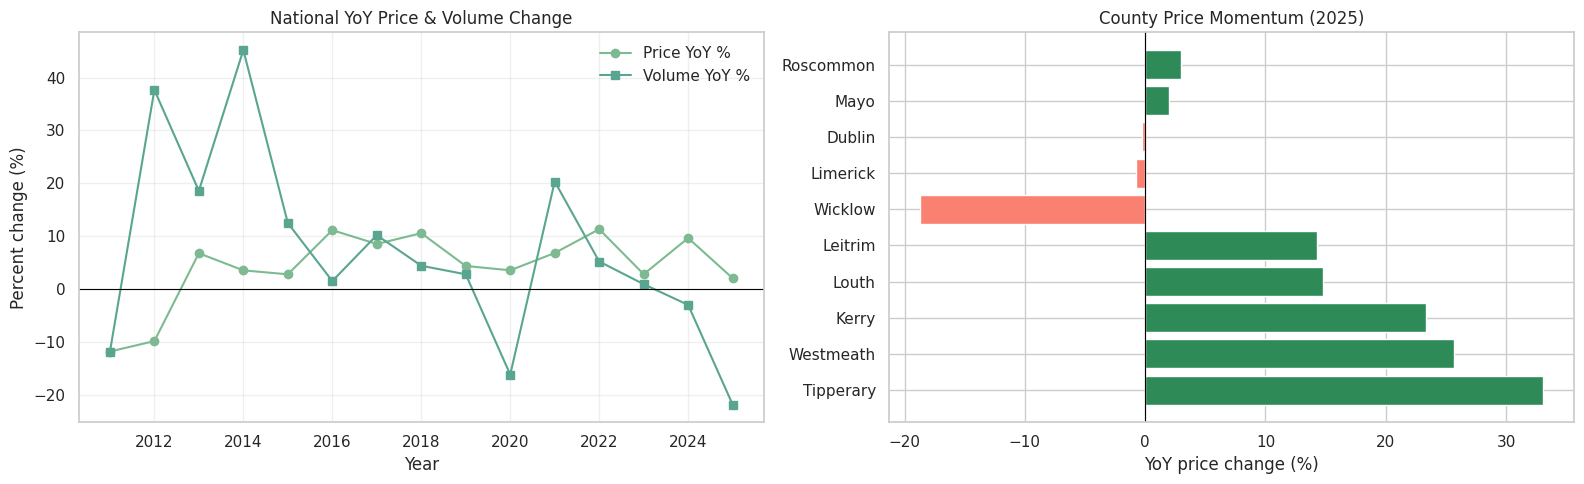

Counties with sustained acceleration (last 3 years):


,county,momentum_label
0,Carlow,Accelerating
1,Cavan,Accelerating
4,Donegal,Accelerating
6,Galway,Accelerating
7,Kerry,Accelerating
8,Kildare,Accelerating
9,Kilkenny,Accelerating
11,Leitrim,Accelerating
14,Louth,Accelerating
15,Mayo,Accelerating


Counties with sustained contraction (last 3 years):


,county,momentum_label


In [6]:
# Year-over-year metrics
county_year = (analysis_df
               .groupby(['county', 'sale_year'])
               .agg(avg_price=('price_eur', 'mean'),
                    median_price=('price_eur', 'median'),
                    volume=('price_eur', 'count'))
               .reset_index())
county_year = county_year.sort_values(['county', 'sale_year'])
county_year['price_yoy_pct'] = county_year.groupby('county')['avg_price'].pct_change() * 100
county_year['volume_yoy_pct'] = county_year.groupby('county')['volume'].pct_change() * 100

national_year = (analysis_df
                 .groupby('sale_year')
                 .agg(avg_price=('price_eur', 'mean'),
                      volume=('price_eur', 'count'))
                 .reset_index())
national_year['price_yoy_pct'] = national_year['avg_price'].pct_change() * 100
national_year['volume_yoy_pct'] = national_year['volume'].pct_change() * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(national_year['sale_year'], national_year['price_yoy_pct'], marker='o', label='Price YoY %')
axes[0].plot(national_year['sale_year'], national_year['volume_yoy_pct'], marker='s', label='Volume YoY %')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_title('National YoY Price & Volume Change')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percent change (%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

latest_year = county_year['sale_year'].max()
latest_snapshot = county_year[county_year['sale_year'] == latest_year].dropna(subset=['price_yoy_pct'])
top_bottom = pd.concat([
    latest_snapshot.nlargest(5, 'price_yoy_pct'),
    latest_snapshot.nsmallest(5, 'price_yoy_pct')
])
axes[1].barh(top_bottom['county'], top_bottom['price_yoy_pct'], color=np.where(top_bottom['price_yoy_pct'] > 0, 'seagreen', 'salmon'))
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title(f'County Price Momentum ({latest_year})')
axes[1].set_xlabel('YoY price change (%)')
plt.tight_layout()
plt.show()

# Momentum detection across last three years
recent_window_start = latest_year - 2
recent_slice = county_year[county_year['sale_year'] >= recent_window_start]
def sustained_acceleration(series):
    last_three = series.tail(3)
    if last_three.isna().all():
        return 'Insufficient data'
    pos = (last_three > 0).sum()
    neg = (last_three < 0).sum()
    if pos >= 3:
        return 'Accelerating'
    if neg >= 3:
        return 'Contracting'
    return 'Mixed'

momentum_flags = (recent_slice.groupby('county')['price_yoy_pct']
                  .apply(sustained_acceleration)
                  .reset_index(name='momentum_label'))
accel_summary = momentum_flags[momentum_flags['momentum_label'] == 'Accelerating'].head(10)
contract_summary = momentum_flags[momentum_flags['momentum_label'] == 'Contracting'].head(10)

print('Counties with sustained acceleration (last 3 years):')
display(accel_summary)
print('Counties with sustained contraction (last 3 years):')
display(contract_summary)

## 3. Buyer Segmentation via Price Bands & Regulatory Flags

/tmp/ipykernel_130278/3728713469.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sale_year', 'price_band'])
/tmp/ipykernel_130278/3728713469.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('price_band')['price_eur']


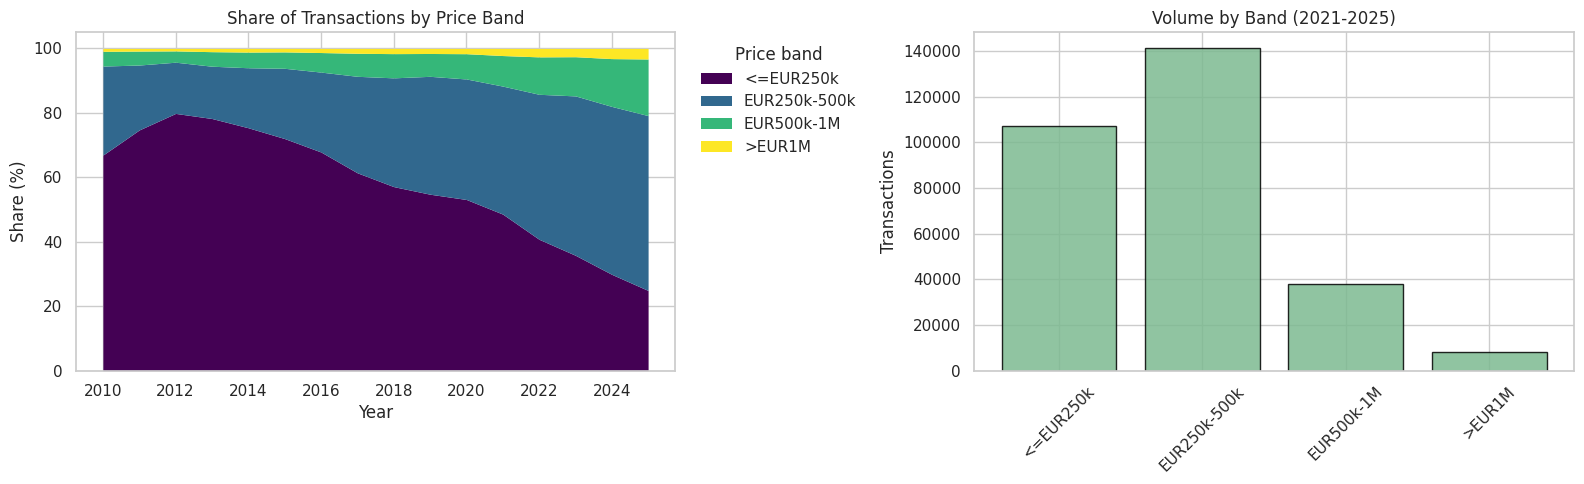

Price band + regulatory indicators:


/tmp/ipykernel_130278/3728713469.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flag_summary = band_df.groupby('price_band').agg(
/tmp/ipykernel_130278/3728713469.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flag_summary['vat_exclusive_rate'] = band_df.groupby('price_band')[vat_col].mean() * 100
/tmp/ipykernel_130278/3728713469.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flag_summary['non_market_ra

,avg_price,vat_exclusive_rate,non_market_rate,share_pct
price_band,,,,
<=EUR250k,"144,308.03",10.97,7.38,53.93
EUR250k-500k,"346,342.87",26.54,2.66,35.42
EUR500k-1M,"660,640.69",16.35,0.92,8.78
>EUR1M,"2,755,621.89",15.95,2.43,1.87


Top counties for >EUR1M segment (recent years):


,transactions,avg_price
county,,
Dublin,6174,"2,815,469.26"
Wicklow,413,"3,212,668.91"
Cork,367,"2,390,803.55"
Kildare,220,"3,100,243.48"
Meath,138,"2,587,589.64"
Galway,123,"2,256,021.04"
Limerick,89,"3,480,264.27"
Wexford,73,"2,725,803.53"
Kerry,67,"2,907,153.83"


In [7]:
# Price band evolution
band_df = analysis_df.dropna(subset=['price_band']).copy()
band_year = (band_df
             .groupby(['sale_year', 'price_band'])
             .size()
             .reset_index(name='transactions'))
band_year['share_pct'] = band_year.groupby('sale_year')['transactions'].transform(lambda x: x / x.sum() * 100)
band_pivot = band_year.pivot(index='sale_year', columns='price_band', values='share_pct').sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
band_pivot.plot.area(ax=axes[0], colormap='viridis', linewidth=0)
axes[0].set_title('Share of Transactions by Price Band')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Share (%)')
axes[0].legend(title='Price band', loc='upper left', bbox_to_anchor=(1.02, 1))

recent_band = (band_df[band_df['sale_year'] >= RECENT_YEAR_START]
               .groupby('price_band')['price_eur']
               .agg(avg_price='mean', transactions='count'))
axes[1].bar(recent_band.index, recent_band['transactions'], edgecolor='black', alpha=0.85)
axes[1].set_title(f'Volume by Band ({RECENT_YEAR_START}-{latest_year})')
axes[1].set_ylabel('Transactions')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Regulatory flag cross-tabs
vat_col = 'vat_exclusive' if 'vat_exclusive' in analysis_df.columns else None
nfmp_col = 'not_full_market_price' if 'not_full_market_price' in analysis_df.columns else None

flag_summary = band_df.groupby('price_band').agg(
    avg_price=('price_eur', 'mean'),
    share=('price_eur', 'count')
)
if vat_col:
    flag_summary['vat_exclusive_rate'] = band_df.groupby('price_band')[vat_col].mean() * 100
if nfmp_col:
    flag_summary['non_market_rate'] = band_df.groupby('price_band')[nfmp_col].mean() * 100
flag_summary['share_pct'] = flag_summary['share'] / flag_summary['share'].sum() * 100

print('Price band + regulatory indicators:')
display(flag_summary.drop(columns='share'))

# County perspective for high-end segment
luxury_recent = band_df[(band_df['price_band'] == '>EUR1M') & (band_df['sale_year'] >= RECENT_YEAR_START)]
county_luxury = (luxury_recent.groupby('county')['price_eur']
                 .agg(transactions='count', avg_price='mean')
                 .sort_values('transactions', ascending=False)
                 .head(10))
print('Top counties for >EUR1M segment (recent years):')
display(county_luxury)

## 4. Eircode Routing-Key Hotspots

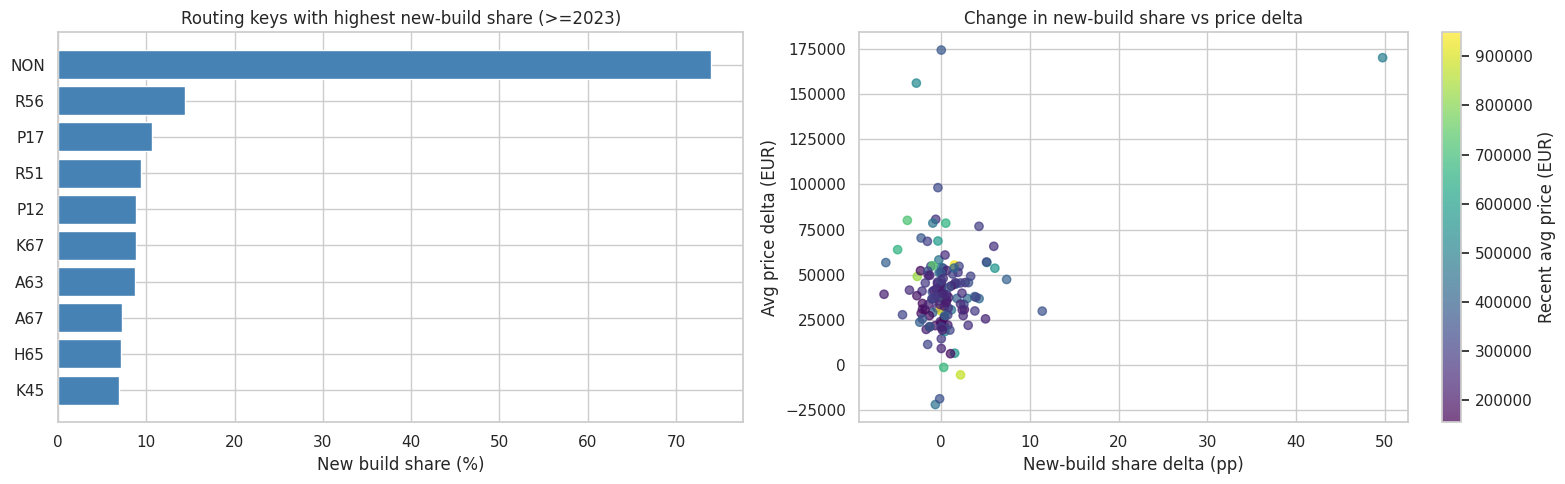

Top routing keys by recent new-build penetration:


,dominant_county,transactions_recent,new_build_share_recent_pct,avg_price_recent
routing_key,,,,
NON,Dublin,42461,73.95,"492,374.90"
R56,Kildare,272,14.34,"354,082.11"
P17,Cork,414,10.63,"566,041.23"
R51,Kildare,470,9.36,"322,345.86"
P12,Cork,317,8.83,"276,363.85"
K67,Dublin,1575,8.83,"403,031.58"
A63,Wicklow,1176,8.67,"578,220.20"
A67,Wicklow,862,7.31,"421,617.15"
H65,Galway,264,7.20,"319,681.27"


Routing keys with largest price lift vs baseline:


,dominant_county,transactions_recent,price_delta,avg_price_recent
routing_key,,,,
E32,Tipperary,277,"174,392.04","374,877.28"
NON,Dublin,42461,"170,172.39","492,374.90"
K78,Dublin,1413,"156,100.63","524,448.73"
P36,Cork,442,"98,272.56","332,227.76"
V14,Clare,259,"80,738.74","267,600.12"
D6W,Dublin,831,"80,160.43","717,045.13"
W23,Kildare,1764,"78,660.83","463,702.47"
D16,Dublin,1504,"78,609.05","661,805.17"
N37,Westmeath,1199,"76,874.16","299,969.19"


Routing keys analyzed: 288 (recent window: >=2023, baseline: 2018-2022)


In [8]:
# Routing-key analysis (first three chars of Eircode)
eir_df = analysis_df[analysis_df['routing_key_available']].copy()
if eir_df.empty:
    print('No eircode data available in the processed dataset.')
else:
    recent_cutoff = latest_year - 2
    baseline_end = recent_cutoff - 1
    baseline_start = max(int(eir_df['sale_year'].min()), baseline_end - 4)

    def routing_group_stats(frame):
        return frame.groupby('routing_key').agg(
            transactions=('price_eur', 'count'),
            avg_price=('price_eur', 'mean'),
            median_price=('price_eur', 'median'),
            new_build_share=('is_new_build', 'mean')
        )

    rk_recent = routing_group_stats(eir_df[eir_df['sale_year'] >= recent_cutoff])
    rk_recent['period'] = f'>={recent_cutoff}'

    if baseline_start <= baseline_end:
        rk_baseline = routing_group_stats(
            eir_df[(eir_df['sale_year'] >= baseline_start) & (eir_df['sale_year'] <= baseline_end)]
        )
        rk_baseline['period'] = f'{baseline_start}-{baseline_end}'
    else:
        rk_baseline = pd.DataFrame(columns=rk_recent.columns)

    # Dominant county mapping
    dominant_county = (eir_df.groupby('routing_key')['county']
                       .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0]))

    rk_compare = rk_recent.join(rk_baseline, lsuffix='_recent', rsuffix='_baseline', how='left')
    rk_compare['dominant_county'] = rk_compare.index.map(dominant_county)
    rk_compare['new_build_share_recent_pct'] = rk_compare['new_build_share_recent'] * 100
    rk_compare['new_build_share_baseline_pct'] = rk_compare['new_build_share_baseline'] * 100
    rk_compare['price_delta'] = rk_compare['avg_price_recent'] - rk_compare['avg_price_baseline']
    rk_compare['new_build_delta_pct'] = rk_compare['new_build_share_recent_pct'] - rk_compare['new_build_share_baseline_pct']

    reliable = rk_compare[rk_compare['transactions_recent'] >= 50].dropna(subset=['avg_price_recent'])

    top_new_build = reliable.sort_values('new_build_share_recent_pct', ascending=False).head(10)
    top_price_delta = reliable.dropna(subset=['price_delta']).sort_values('price_delta', ascending=False).head(10)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].barh(top_new_build.index, top_new_build['new_build_share_recent_pct'], color='steelblue')
    axes[0].set_title(f'Routing keys with highest new-build share (>={recent_cutoff})')
    axes[0].set_xlabel('New build share (%)')
    axes[0].invert_yaxis()

    scatter = axes[1].scatter(reliable['new_build_delta_pct'], reliable['price_delta'],
                              c=reliable['avg_price_recent'], cmap='viridis', alpha=0.7)
    axes[1].set_title('Change in new-build share vs price delta')
    axes[1].set_xlabel('New-build share delta (pp)')
    axes[1].set_ylabel('Avg price delta (EUR)')
    plt.colorbar(scatter, ax=axes[1], label='Recent avg price (EUR)')
    plt.tight_layout()
    plt.show()

    print('Top routing keys by recent new-build penetration:')
    display(top_new_build[['dominant_county', 'transactions_recent', 'new_build_share_recent_pct', 'avg_price_recent']])

    print('Routing keys with largest price lift vs baseline:')
    display(top_price_delta[['dominant_county', 'transactions_recent', 'price_delta', 'avg_price_recent']])

    coverage = eir_df['routing_key'].nunique()
    print(f"Routing keys analyzed: {coverage} (recent window: >={recent_cutoff}, baseline: {baseline_start}-{baseline_end})")

## 5. Key Takeaways
- Seasonality analysis now shows how the last five years deviate from the long-run baseline, highlighting peak pricing months and any heatmap anomalies.
- County momentum flags surface acceleration/slowdown clusters for triaging local market cycles.
- Price-band views link affordability tiers with VAT and non-full-market indicators, plus expose where luxury demand concentrates.
- Routing-key rollups reveal specific eircode areas where surging new-build penetration aligns with price lifts, guiding hyper-local monitoring.